# Stocks demo pipeline

## steps
* [Run notebook ingest_stocks](01_ingest_news.ipynb)
* [Run notebook ingest_news](02_ingest_stocks.ipynb)
* [Create feature vector](#Create-feature-vector)
* [Set up the project](#Set-up-the-project)
* [Write and save workflow](#Write-and-save-workflow)
* [Run the workflow](#Run-the-workflow)

In [2]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="./")

> 2022-11-08 11:51:18,173 [info] loaded project stocks from MLRun DB


# Create feature vector

In [3]:
# Define the list of features we will be using
features = ['stocks.*',
            'news.sentiment',
            ]

# Import MLRun's Feature Store
import mlrun.feature_store as fstore

# Define the feature vector name for future reference
fv_name = 'stocks'

# Define the feature vector using our Feature Store (fstore)
transactions_fv = fstore.FeatureVector(fv_name, 
                          features, 
                          description='stocks information')

# Save the feature vector in the Feature Store
transactions_fv.save()

In [4]:
# Get offline feature vector as dataframe and save the dataset to parquet
import datetime
start_time = datetime.datetime.now()-datetime.timedelta(59)
end_time = end_time = datetime.datetime.now()-datetime.timedelta(0)
fv_data = fstore.get_offline_features(fv_name,start_time=start_time,end_time=end_time, entity_timestamp_column = 'Datetime')
fv_data.to_dataframe().head()

,Open,High,Low,Close,Volume,ticker2onehot_A,ticker2onehot_ABBV,ticker2onehot_ABT,ticker2onehot_ABMD,ticker2onehot_AAPL,ticker2onehot_AAP,ticker2onehot_ACN,ticker2onehot_ABC,ticker2onehot_ACGL,ticker2onehot_AAL,sentiment
0,14.370000,14.575000,14.370000,14.525000,1391313,0,0,0,0,0,0,0,0,0,1,NaN
1,159.634201,160.369995,159.509995,160.330002,4839065,0,0,0,0,1,0,0,0,0,0,NaN
2,137.529999,137.889999,137.229996,137.869995,30482,1,0,0,0,0,0,0,0,0,0,NaN
3,108.779999,109.168999,108.599998,108.889999,98389,0,0,1,0,0,0,0,0,0,0,NaN
4,182.000000,182.587097,181.619995,182.509995,0,0,0,0,0,0,1,0,0,0,0,NaN


## Set up the project

In [5]:
import os

# getting our model training function
project.set_function('./src/train_stocks.py',
                     name='train_stocks', kind='job', image='mlrun/ml-models')


project.set_function('./src/serving_stocks.py',
                     name='serving_stocks', kind='serving', image='mlrun/ml-models')

## Write and save workflow

In [6]:
%%writefile src/workflow.py
import mlrun
from kfp import dsl
from mlrun import get_or_create_ctx

@dsl.pipeline(
    name="Stocks Prediction Pipeline",
    description="predicting stock prices using yahoo api with sentiment analysis"
)

def kfpipeline(vector_name:str,
               seq_size:int = 5,
               batch_size:int = 1,
               hidden_dim:int = 2,
               n_layers:int = 1,
               epochs:int = 3,
               start_time:int = 59,
               end_time:int = 0,
               model_filepath = './'
               ):

    ctx = get_or_create_ctx(name='kfp-context')

    project = mlrun.get_current_project()

    project.get_function('train_stocks').apply(mlrun.auto_mount())

    train_stocks_run = mlrun.run_function(name='train_stocks',
                                          function='train_stocks',
                                          handler='handler',
                                          params={'context':ctx,
                                                  'hidden_dim':hidden_dim,
                                                  'n_layers':n_layers,
                                                  'epochs':epochs,
                                                  'vector_name':vector_name,
                                                  'seq_size':seq_size,
                                                  'start_time':start_time,
                                                  'end_time':end_time,
                                                  'batch_size':batch_size,
                                                  'model_filepath':model_filepath},
                                          outputs=["model"])


    # deploying serving function
    serving_function = project.get_function("serving_stocks")
    # Mount it:
    serving_function.apply(mlrun.mount_v3io())
    # Set the topology and get the graph object:
    graph = serving_function.set_topology("flow", engine="async")
    # Build the serving graph:
    graph.to(handler='preprocess', name='reading_data')\
         .to(class_name="StocksModel", model_name='stocks_model', model_path=str(train_stocks_run.outputs['model']))\
         .to(handler='postprocess',name='postprocess').respond()


    # Set the desired requirements:
    serving_function.with_requirements(requirements=['yfinance','yahoo_fin'])
    # Deploy the serving function:
    mlrun.deploy_function("serving_stocks")

Writing src/workflow.py


In [ ]:
import os

# get source help function
def get_source_path():
    cwd = os.getcwd()
    user_name = os.environ['V3IO_USERNAME']
    replacement_string = 'v3io:///users/'+user_name
    source_path = cwd.replace('/User',replacement_string)+'/project.tar.gz'
    print('source_path: ' + source_path)
    return source_path

In [7]:
import shutil

shutil.make_archive('project','gztar','./')
source_path = get_source_path()

project.set_source(source_path,pull_at_runtime=True)

# Register the workflow file:
workflow_name = "stocks_workflow"
project.set_workflow(name=workflow_name, workflow_path="src/workflow.py",schedule='0 0 * * */1')

project.save()


## Run the workflow

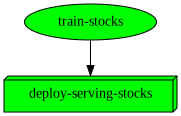

> 2022-11-08 12:05:36,662 [warning] No slack webhook is set, skipping notification
[info] Workflow 88e1d763-207e-46f6-a786-8ffd4401889d finished, state=Succeeded
status     name          uid       results
---------  ------------  --------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
completed  train_stocks  ..4fea3e  context=<nuclio.request.Context object at 0x7fa6a6b0ad90>,hidden_dim=2,n_layers=1,epochs=5,vector_name=stocks,seq_size=5,start_time=59,end_time=0,batch_size=1,model_filepath=/User/test/demos/stocks-prediction/src,lr=0.0001,training_MSELoss=2.0057511846971465e-06,training_accuracy=0.9985837545245886,validation_MSELoss=0.0003246353880967945,vali

uid,start,state,name,parameters,results
...e54fea3e,Nov 08 11:51:36,completed,train_stocks,context=hidden_dim=2n_layers=1epochs=5vector_name=stocksseq_size=5start_time=59end_time=0batch_size=1model_filepath=/User/test/demos/stocks-prediction/src,context=hidden_dim=2n_layers=1epochs=5vector_name=stocksseq_size=5start_time=59end_time=0batch_size=1model_filepath=/User/test/demos/stocks-prediction/srclr=0.0001training_MSELoss=2.0057511846971465e-06training_accuracy=0.9985837545245886validation_MSELoss=0.0003246353880967945validation_accuracy=0.9881337806582451


88e1d763-207e-46f6-a786-8ffd4401889d

In [8]:
project.run(workflow_name,
            arguments={
                "vector_name":"stocks",
                "seq_size": 5,
                "batch_size": 1,
                "hidden_dim": 2,
                "n_layers": 1,
                "epochs": 3,
                "start_time":59,
                "end_time":0,
                "model_filepath":'./'},
            watch=True,schedule=True)